In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.3f}'.format

2023-10-06 02:23:12.996471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:12.996510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 0. Functions 

### 0.1. Encoding functions

In [2]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
############################################################

### 0.2. Split Data Function

In [3]:
def train_valid_sets(X_train_set, X_valid_set):
    #######################################
    ### BALANCED DATA
    #######################################
    random.seed(2)
    X_0 = X_train_set[X_train_set['Mortality'] == 0]
    X_1 = X_train_set[X_train_set['Mortality'] == 1]

    list_X_0 = random.sample(range(len(X_0)),len(X_1))
    X_0_2 = X_0.iloc[list_X_0]

    X_data_bal = pd.concat([X_1,X_0_2])
    
    #######################################
    ### SPLIT DATA
    #######################################
    
    train_set = X_data_bal
    valid_set = X_valid_set

    print('total admissions 16 18', len(X_train_set))
    print('total admissions 19 20', len(X_valid_set))
    print('X_train', len(train_set))
    print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
          'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
    print('X_valid', len(valid_set))
    print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
          'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))
    return train_set, valid_set

### 0.3. Encoding Data Function

In [4]:
def encoding_data(train_set, valid_set, feat_list, data_types):
    ############################################################
    train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
    valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)
    print("==========================================================================================================")
    print('----------------------------------TRAIN SET---------------------------------------------------------------')
    print("==========================================================================================================")
    display(train_set.head(4))
    display(train_set_norm.head(4))
    print("==========================================================================================================")
    print('----------------------------------VALIDATION SET----------------------------------------------------------')
    print("==========================================================================================================")
    display(valid_set.head(4))
    display(valid_set_norm.head(4))
    display(encoder)
    return train_set_norm, valid_set_norm, encoder

# 1. Load Data

In [5]:
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

X_data_16_18 = pickle.load(open(path + 'df_first_curb_2016_18.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_first_curb_2019_20.pickle','rb'))


print("=================================FIRST RECORDED SAMPLE ADMISSION=================================")
print("-------------------------------------- 2016 - 2018 ----------------------------------------------")
display(X_data_16_18[0].head(3))
print("")
print("-------------------------------------- 2019 - 2020 ----------------------------------------------")
display(X_data_19_20[0].head(3))

print("Elapsed time:", time.time()-t)

=================================FIRST RECORDED SAMPLE ADMISSION=================================
-------------------------------------- 2016 - 2018 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,67812046,25.000,6,116.000,37.500,150.000,82.000,94.000,1.000,1,1,0,40,0,0,0.000,0
144,52393258,18.000,4,94.000,36.300,136.000,67.000,99.000,1.000,1,-1,0,53,2,0,0.000,0
288,62865417,28.000,5,109.000,38.200,112.000,76.000,99.000,1.000,1,1,0,47,0,1,1.000,0



-------------------------------------- 2019 - 2020 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,6361876,26.000,8,132.000,37.400,183.000,77.000,100.000,1.000,0,-1,1,57,3,1,1.000,0
144,66737446,20.000,0,65.000,37.100,142.000,76.000,99.000,0.000,0,1,8,68,0,0,0.000,0
288,34224926,18.000,4,64.000,36.600,130.000,64.000,92.000,1.000,0,-1,0,74,3,1,1.000,0


Elapsed time: 0.022995710372924805


In [6]:
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 15


In [7]:
# Loading the CSV with types
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# Modelling parameters NN Classfier

In [8]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from tensorflow.keras.constraints import MaxNorm as maxnorm

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define grid
batch_size   = [10, 20, 60, 100]
epochs       = [10, 50, 100]
dropout_rate = [0.2, 0.5]
param_grid = dict(batch_size=batch_size, epochs=epochs, dropout_rate=dropout_rate)

scoring = {"AUC": "roc_auc", "Recall": "recall"}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

def create_model(dropout_rate = 0.0):
    model = Sequential()
    model.add(LSTM(80, activation='relu', input_shape=(1, 15)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # create model
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring, refit = "Recall")

# 2. Modelling LSTM classifier

In [9]:


def train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list):
    df_results_train = pd.DataFrame()
    df_results       = pd.DataFrame()
    dict_fpr_tpr     = {}
    X_train = np.array(train_set[feat_list]); Y_train = np.array(X_train_set['Mortality'])
    X_valid = np.array(valid_set[feat_list]); Y_valid = np.array(X_valid_set['Mortality'])
    
    X_train = X_train.reshape(len(train_set),1,15); X_valid = X_valid.reshape(len(valid_set),1,15)
    #################################################################
    #################################################################
    # TRAINING THE MODEL
    #################################################################
    t = time.time()
    # execute the grid search
    grid_result = grid.fit(X_train, Y_train)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    auc_means = grid_result.cv_results_['mean_test_AUC']
    rcl_means = grid_result.cv_results_['mean_test_Recall']
    params    = grid_result.cv_results_['params']
    print("AUC    (call)")
    for mean, rcl, param in zip(auc_means, rcl_means, params):
        print("%f (%f) with: %r" % (mean, rcl, param))    
    df_results_train['NoF_auc'] = auc_means
    df_results_train['NoF_rcl'] = rcl_means
    print("")
    print("time elapased training: ", time.time()-t)
    #################################################################
    #################################################################
    # results - Model Validation
    #################################################################

    y_scores  = grid.predict(X_valid)
    y_predict = FineTuning.adjusted_classes(y_scores, 0.5)
    y_proba   = grid.predict_proba(X_valid)[:,1]
    df_results, fpr_tpr = LearningCurves.results_precision_recall_cm(Y_valid, y_predict, y_proba, fig_size = None)
    plt.show()
    dict_fpr_tpr['NoF'] = fpr_tpr
    df_results = df_results.set_index(pd.Series('NoF'))
    display(df_results)
    return [df_results_train, df_results, dict_fpr_tpr]

# CURB65 Group 1

In [10]:
X_data_16_18[0]

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,67812046,25.000,6,116.000,37.500,150.000,82.000,94.000,1.000,1,1,0,40,0,0,0.000,0
144,52393258,18.000,4,94.000,36.300,136.000,67.000,99.000,1.000,1,-1,0,53,2,0,0.000,0
288,62865417,28.000,5,109.000,38.200,112.000,76.000,99.000,1.000,1,1,0,47,0,1,1.000,0
432,26501865,17.000,1,105.000,37.700,135.000,75.000,97.000,1.000,1,1,0,88,0,0,1.000,0
576,95636416,21.000,6,87.000,38.200,121.000,60.000,93.000,1.000,1,1,0,62,1,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166896,37232584,22.000,9,120.000,36.300,155.000,87.000,81.000,1.000,0,-1,0,73,0,0,1.000,0
167040,8274181,20.000,2,76.000,36.700,165.000,86.000,96.000,1.000,0,-1,0,87,0,0,0.000,0
167184,85711282,19.000,1,87.000,36.800,104.000,86.000,96.000,1.000,1,1,0,38,0,0,1.000,0
167328,74171937,22.000,8,138.000,37.400,106.000,78.000,97.000,1.000,0,1,0,81,1,0,1.000,0


In [11]:
X_train_set = X_data_16_18[0]
X_valid_set = X_data_19_20[0]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1164
total admissions 19 20 411
X_train 102
Admissions neg (mortal - class = 0): 51 Admissions pos (recover- class = 1): 51
X_valid 411
Admissions neg (mortal - class = 0): 380 Admissions pos (recover- class = 1): 31

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
1008,55288256,26.000,5,90.000,37.500,177.000,93.000,96.000,1.000,0,1,0,86,4,0,1.000,1
3456,77389441,32.000,10,115.000,36.800,127.000,83.000,90.000,1.000,0,-1,0,60,8,1,1.000,1
10656,76701653,24.000,7,112.000,36.000,137.000,67.000,100.000,1.000,0,1,0,87,8,0,0.000,1
13248,99593683,20.000,5,97.000,38.700,171.000,104.000,86.000,1.000,1,-1,0,91,1,0,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
1008,1.171,0.529,-0.552,0.237,2.098,1.166,0.421,1.000,0,1,0.536,1.381,1.320,0,1.000
3456,2.858,0.833,0.741,-0.468,-0.115,0.429,-1.225,1.000,0,-1,0.536,-0.384,3.440,1,1.000
10656,0.608,0.636,0.586,-1.273,0.328,-0.750,1.518,1.000,0,1,0.536,1.449,3.440,0,0.000
13248,-0.517,0.529,-0.190,1.444,1.833,1.976,-2.322,1.000,1,-1,0.536,1.721,-0.270,0,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,6361876,26.000,8,132.000,37.400,183.000,77.000,100.000,1.000,0,-1,1,57,3,1,1.000,0
144,66737446,20.000,0,65.000,37.100,142.000,76.000,99.000,0.000,0,1,8,68,0,0,0.000,0
288,34224926,18.000,4,64.000,36.600,130.000,64.000,92.000,1.000,0,-1,0,74,3,1,1.000,0
432,526683,20.000,3,95.000,36.700,127.000,89.000,97.000,1.000,0,1,0,48,0,0,1.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,1.171,0.500,1.621,0.136,2.364,-0.013,1.518,1.000,0,-1,0.500,-0.588,0.790,1,1.000
144,-0.517,0.750,-1.846,-0.166,0.549,-0.087,1.244,0.000,0,1,0.000,0.159,-0.800,0,0.000
288,-1.080,0.600,-1.897,-0.669,0.018,-0.971,-0.676,1.000,0,-1,0.536,0.566,0.790,1,1.000
432,-0.517,0.286,-0.293,-0.568,-0.115,0.871,0.695,1.000,0,1,0.536,-1.199,-0.800,0,1.000


,feature,type,parameters
0,rr,Continuous,"[21.83823529411765, 3.5551954484615598]"
1,ews,Categorical,0 1 prob 5 8 9 0.529 10 1 5 0.833 7...
2,heart_rate,Continuous,"[100.67156862745098, 19.32736416161908]"
3,temperature,Continuous,"[37.264705882352935, 0.9937076346357473]"
4,sbp,Continuous,"[129.58823529411765, 22.597359409907263]"
5,dbp,Continuous,"[77.17647058823529, 13.573716422517762]"
6,Oxygen_Saturation,Continuous,"[94.4656862745098, 3.6453278139145255]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############


2023-10-06 02:23:23.956021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:23.956113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 02:23:24.161877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:24.161915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 02:23:24.462995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2023-10-06 02:23:26.345091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:26.345120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 02:23:26.368203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:26.368234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 02:23:26.369117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2023-10-06 02:23:27.756293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:27.756328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 02:23:27.769114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 02:23:27.769154: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 02:23:27.849098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2023-10-06 02:23:34.461697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:23:34.461728: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:23:34.461759: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:23:34.462028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 02:23:34.592215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dy

2023-10-06 02:23:35.243411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:23:35.243444: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:23:35.243471: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:23:35.243694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 02:23:35.298129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dy

2023-10-06 02:23:35.673701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:23:35.673735: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:23:35.673766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:23:35.673988: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 02:23:35.763654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dy

2023-10-06 02:23:36.573059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:23:36.573092: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:23:36.573139: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:23:36.573456: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 02:23:36.646881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dy

2023-10-06 02:23:37.161029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-06 02:23:37.161578: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2395570000 Hz
2023-10-06 02:23:37.342226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:23:37.342262: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:23:37.342297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:23:37.342576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

2023-10-06 02:23:38.779564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-06 02:23:38.780262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2395570000 Hz
2023-10-06 02:23:38.848873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:23:38.848917: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:23:38.848955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:23:38.849910: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

2023-10-06 02:23:40.662370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-06 02:23:40.663089: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2395570000 Hz
2023-10-06 02:23:40.868961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-06 02:23:40.869432: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2395570000 Hz
2023-10-06 02:23:41.173856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-06 02:23:41.238564: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2395570000 Hz
2023-10-06 02:23:41.257108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared obj

2023-10-06 02:24:32.822357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-06 02:24:32.823305: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-06 02:24:32.823910: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login01): /proc/driver/nvidia/version does not exist
2023-10-06 02:24:32.827683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 02:24:33.130334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR 

Best: 0.614379 using {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
AUC    (call)
0.529412 (0.542484) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.593618 (0.581699) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.586890 (0.601307) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.522107 (0.594771) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.575163 (0.542484) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.569204 (0.555556) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.551134 (0.581699) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.551326 (0.542484) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.581699 (0.529412) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.544022 (0.614379) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.593618 (0.594771) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.537870 (0.470588) with: {'

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confidence interval for the score: [0.562 - 0.717]


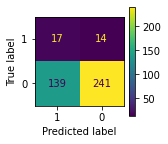

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.109,0.548,0.182,0.628,0.641,0.220,"[0.56, 0.717]"


In [12]:
print("############### Results without encoding ##############")
results1     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.738562 using {'batch_size': 100, 'dropout_rate': 0.2, 'epochs': 10}
AUC    (call)
0.628604 (0.699346) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.613995 (0.666667) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.594002 (0.640523) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.622453 (0.542484) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.621684 (0.686275) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.609765 (0.640523) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.614379 (0.549020) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.637832 (0.633987) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.612457 (0.673203) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.619377 (0.549020) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.635909 (0.647059) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.605152 (0.653595) with: {

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confidence interval for the score: [0.602 - 0.743]


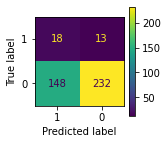

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.108,0.581,0.183,0.608,0.675,0.247,"[0.6, 0.743]"


In [13]:
print("############### Results encoded data ##############")
results1_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# CURB65 Group 2

In [14]:
X_train_set = X_data_16_18[1]
X_valid_set = X_data_19_20[1]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1046
total admissions 19 20 392
X_train 222
Admissions neg (mortal - class = 0): 111 Admissions pos (recover- class = 1): 111
X_valid 392
Admissions neg (mortal - class = 0): 331 Admissions pos (recover- class = 1): 61

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
288,88574915,20.000,0,78.000,36.500,136.000,72.000,96.000,1.000,1,-1,0,79,7,1,1.000,1
720,18209965,20.000,0,87.000,36.900,115.000,76.000,96.000,1.000,1,-1,0,85,1,0,1.000,1
864,79826616,24.000,4,79.000,36.200,111.000,57.000,96.000,1.000,0,-1,0,79,5,0,1.000,1
1584,85889623,16.000,1,50.000,36.600,155.000,97.000,96.000,1.000,1,1,0,93,2,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
288,-0.470,0.529,-0.751,-0.539,0.498,0.106,0.455,1.000,1,-1,0.503,0.029,2.682,1,1.000
720,-0.470,0.529,-0.278,-0.121,-0.420,0.373,0.455,1.000,1,-1,0.503,0.675,-0.525,0,1.000
864,0.397,0.625,-0.698,-0.854,-0.595,-0.895,0.455,1.000,0,-1,0.503,0.029,1.613,0,1.000
1584,-1.337,0.333,-2.222,-0.435,1.329,1.775,0.455,1.000,1,1,0.503,1.537,0.010,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,81895617,28.000,6,72.000,37.800,161.000,76.000,93.000,0.000,1,-1,8,93,0,1,0.000,1
144,27214872,24.000,4,73.000,37.200,124.000,64.000,98.000,0.000,1,1,0,73,3,1,1.000,0
288,52483090,18.000,4,110.000,38.400,156.000,92.000,96.000,1.000,0,-1,1,67,8,1,1.000,1
432,50639294,18.000,0,57.000,36.300,135.000,106.000,96.000,0.000,0,-1,0,84,2,1,0.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,1.263,0.438,-1.066,0.822,1.591,0.373,-0.266,0.000,1,-1,0.600,1.537,-1.059,1,0.000
144,0.397,0.625,-1.013,0.194,-0.026,-0.428,0.936,0.000,1,1,0.503,-0.617,0.544,1,1.000
288,-0.903,0.625,0.931,1.450,1.373,1.441,0.455,1.000,0,-1,1.000,-1.263,3.216,1,1.000
432,-0.903,0.529,-1.854,-0.749,0.454,2.375,0.455,0.000,0,-1,0.503,0.567,0.010,1,0.000


,feature,type,parameters
0,rr,Continuous,"[22.16891891891892, 4.615248943218096]"
1,ews,Categorical,0 1 prob 0 8 9 0.529 4 9 15 0...
2,heart_rate,Continuous,"[92.28153153153153, 19.02560245498206]"
3,temperature,Continuous,"[37.015090090090084, 0.9547853948495921]"
4,sbp,Continuous,"[124.6036036036036, 22.87523875375411]"
5,dbp,Continuous,"[70.41216216216216, 14.981442089084984]"
6,Oxygen_Saturation,Continuous,"[94.10585585585585, 4.161209789382788]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.639640 using {'batch_size': 100, 'dropout_rate': 0.2, 'epochs': 10}
AUC    (call)
0.596827 (0.528529) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.609610 (0.501502) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.621297 (0.564565) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.605470 (0.591592) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.613789 (0.606607) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.619917 (0.513514) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.577145 (0.594595) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.624868 (0.606607) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.575765 (0.528529) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.596867 (0.504505) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.626978 (0.633634) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.604740 (0.525526) with: {

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confidence interval for the score: [0.387 - 0.515]


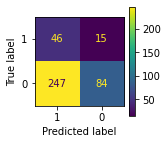

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.157,0.754,0.260,0.332,0.451,0.308,"[0.39, 0.515]"


In [15]:
print("############### Results without encoding ##############")
results2     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.681682 using {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
AUC    (call)
0.715851 (0.669670) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.641344 (0.597598) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.636150 (0.600601) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.715039 (0.666667) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.647756 (0.621622) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.641993 (0.585586) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.725672 (0.681682) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.665693 (0.585586) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.648243 (0.600601) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.717150 (0.672673) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.672023 (0.612613) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.632903 (0.603604) with: {'

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confidence interval for the score: [0.605 - 0.727]


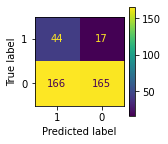

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.210,0.721,0.325,0.533,0.670,0.247,"[0.6, 0.727]"


In [16]:
print("############### Results encoded data ##############")
results2_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# CURB65 Group 3

In [17]:
X_train_set = X_data_16_18[2]
X_valid_set = X_data_19_20[2]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1109
total admissions 19 20 265
X_train 404
Admissions neg (mortal - class = 0): 202 Admissions pos (recover- class = 1): 202
X_valid 265
Admissions neg (mortal - class = 0): 211 Admissions pos (recover- class = 1): 54

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
432,72731410,16.000,1,45.000,37.400,116.000,40.000,100.000,1.000,1,-1,0,94,4,1,0.000,1
1872,4942885,27.000,7,118.000,36.500,121.000,89.000,96.000,1.000,0,-1,0,82,1,1,1.000,1
3312,87226510,33.000,7,98.000,36.800,196.000,85.000,85.000,1.000,1,-1,0,74,3,1,0.000,1
3744,16427207,28.000,7,91.000,37.000,86.000,54.000,96.000,1.000,1,1,0,77,0,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
432,-1.265,0.375,-2.231,0.346,-0.168,-1.660,1.155,1.000,1,-1,0.494,1.337,1.212,1,0.000
1872,0.499,0.512,1.108,-0.634,0.049,1.191,0.316,1.000,0,-1,0.494,-0.049,-0.588,1,1.000
3312,1.462,0.512,0.193,-0.307,3.306,0.958,-1.989,1.000,1,-1,0.494,-0.973,0.612,1,0.000
3744,0.660,0.512,-0.127,-0.089,-1.471,-0.845,0.316,1.000,1,1,0.494,-0.627,-1.188,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,65992687,19.000,2,65.000,37.000,121.000,54.000,93.000,0.000,0,-1,0,85,6,1,1.000,0
144,38145648,18.000,3,90.000,39.000,137.000,53.000,93.000,0.000,0,1,0,83,1,0,1.000,1
288,97015690,24.000,4,84.000,38.000,94.000,45.000,96.000,0.000,0,-1,0,83,0,0,1.000,0
432,70092764,22.000,8,83.000,37.400,104.000,55.000,90.000,1.000,0,-1,0,74,4,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.784,0.417,-1.316,-0.089,0.049,-0.845,-0.312,0.000,0,-1,0.494,0.297,2.411,1,1.000
144,-0.944,0.512,-0.173,2.089,0.744,-0.903,-0.312,0.000,0,1,0.494,0.066,-0.588,0,1.000
288,0.018,0.561,-0.447,1.000,-1.124,-1.369,0.316,0.000,0,-1,0.494,0.066,-1.188,0,1.000
432,-0.303,0.452,-0.493,0.346,-0.689,-0.787,-0.941,1.000,0,-1,0.494,-0.973,1.212,1,1.000


,feature,type,parameters
0,rr,Continuous,"[23.887376237623762, 6.234882584357485]"
1,ews,Categorical,0 1 prob 1 20 12 0.375 7 21 22 0...
2,heart_rate,Continuous,"[93.77351485148515, 21.859466926595335]"
3,temperature,Continuous,"[37.08205445544555, 0.9179859749086493]"
4,sbp,Continuous,"[119.87747524752476, 23.02812419159461]"
5,dbp,Continuous,"[68.52722772277228, 17.18792643468642]"
6,Oxygen_Saturation,Continuous,"[94.49009900990099, 4.7722212098280306]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.658326 using {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
AUC    (call)
0.608402 (0.581358) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.636060 (0.553141) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.643103 (0.658326) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.608658 (0.571383) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.639352 (0.621354) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.635020 (0.577017) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.583788 (0.465833) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.639667 (0.635255) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.638924 (0.562189) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.614757 (0.656936) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.624446 (0.628475) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.625812 (0.656668) with: {

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confidence interval for the score: [0.600 - 0.726]


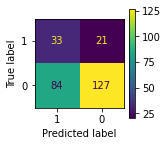

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.282,0.611,0.386,0.604,0.665,0.235,"[0.6, 0.726]"


In [18]:
print("############### Results without encoding ##############")
results3     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.679982 using {'batch_size': 100, 'dropout_rate': 0.5, 'epochs': 50}
AUC    (call)
0.684161 (0.658546) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.614773 (0.643620) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.582945 (0.574212) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.686675 (0.666667) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.599659 (0.614086) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.594153 (0.595747) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.686136 (0.673422) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.642758 (0.661984) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.585825 (0.581016) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.684180 (0.676544) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.631468 (0.635499) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.588514 (0.615647) with: {

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confidence interval for the score: [0.615 - 0.742]


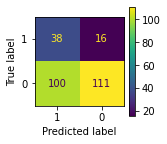

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.275,0.704,0.396,0.562,0.680,0.244,"[0.62, 0.742]"


In [19]:
print("############### Results encoded data ##############")
results3_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# Results

# AUROC curve

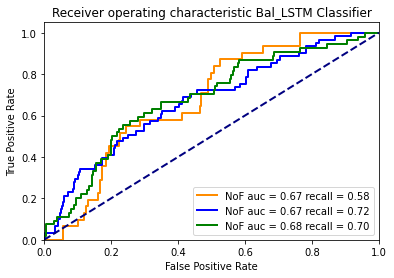

In [20]:
title = 'Bal_LSTM Classifier'
plt.figure()
colors = ['darkorange', 'b','g','r','c', 'm']
i = 0

results_encs =[results1_enc, results2_enc, results3_enc]

for results_enc in results_encs:

    df_results_valid = results_enc[1]
    dict_fpr_tpr     = results_enc[2]

    key = 'NoF'
    val = dict_fpr_tpr[key]
    auc = df_results_valid.loc[key,'AUC']
    rcl = df_results_valid.loc[key,'Recall']
    fpr, tpr = val

    lw = 2

    plt.plot(fpr,  tpr,  color= colors[i],  lw=lw,label= key + " auc = {:,.2f} recall = {:,.2f}".format(auc, rcl) 
        #label="ROC curve (area = %0.2f)" % metrics.roc_auc[2],
    )
    i = i + 1
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic "+ title)
plt.legend(loc="lower right")
#plt.savefig('AUROC_'+title+'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [21]:
pickle.dump([results_encs], open('dict_fpr_trp_'+title+'.pickle', 'wb'))

In [22]:
for r in results_encs:
    display(r[1])

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.108,0.581,0.183,0.608,0.675,0.247,"[0.6, 0.743]"


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.210,0.721,0.325,0.533,0.670,0.247,"[0.6, 0.727]"


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.275,0.704,0.396,0.562,0.680,0.244,"[0.62, 0.742]"
